# DEV - K-Means

In this notebook, BigQuery ML (BQML) is used to do K-means clustering while using hyperparameter tuning to find an optimal value for the number of clusters.

**K-Means Clustering**

K-means clustering is a statistical technique to partition `n` observations into `k` clusters.  Each obsevation will belong, be assigned, to a cluster that has the nearest mean.

Reference:
    - [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering)
    - [Unsupervised Learning](https://en.wikipedia.org/wiki/Unsupervised_learning)

**BigQuery ML (BQML)**

BigQuery has a number of machine learning algorithms callable directly from SQL.  This gives the convenience of using the common language of `SQL` with statments like `CREATE MODEL …`.  The library of available models is constantly growing and covers supervised, unsupervised, and time series methods as well as functions for evaluation - even anomaly detection from results, explainability and hyperparameter tuning.  A great starting point for seeing the scope of available methods is the [user journey for models](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey).

**Hyperparameter Tuning**

When training a machine learning model it is helpful to find the optimal values for hyperparameters, parameters set before training begins.  These are not learned parameters like the coefficents of a model.  Rather than manually iterating these parameters we want to sequently test and focus in on optimal values.  The focusing part of the iterations is done in BQML by utilizing the [Vertex AI Vizier](https://cloud.google.com/vertex-ai/docs/vizier/overview) service by default.

Each `MODEL_TYPE` in BQML has parameters than can be tuned as [listed here](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-hyperparameter-tuning#hyperparameters_and_objectives). 

**Prerequisites:**
- [01 - BigQuery - Table Data Source](../01%20-%20Data%20Sources/01%20-%20BigQuery%20-%20Table%20Data%20Source.ipynb)

**Resources:**
-  [BigQuery ML (BQML) Overview](https://cloud.google.com/bigquery-ml/docs/introduction)
-  [Overview of BQML methods and workflows](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey)

**Conceptual Flow & Workflow**


---
## Setup

inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [2]:
REGION = 'us-central1'
EXPERIMENT = 'kmeans'
SERIES = '03'

# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'fraud'
BQ_TABLE = 'fraud_prepped'

# Resources for serving BigQuery Model Exports
TF_DEPLOY_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest'
XGB_DEPLOY_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.0-82:latest'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters

packages:

In [3]:
from google.cloud import bigquery
from google.cloud import aiplatform
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import metrics

clients:

In [4]:
bq = bigquery.Client()
aiplatform.init(project=PROJECT_ID, location=REGION)

parameters:

In [5]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{SERIES}/{EXPERIMENT}"
RUN_NAME = f'run-{TIMESTAMP}'

BQ_MODEL = f'{SERIES}_{EXPERIMENT}_{TIMESTAMP}'

---
## Review Data

The data source here was prepared in [01 - BigQuery - Table Data Source](../01%20-%20Data%20Sources/01%20-%20BigQuery%20-%20Table%20Data%20Source.ipynb).  In this notebook we will use prepared BigQuery table to build a model with BigQuery ML (BQML).

This is a table of 284,807 credit card transactions classified as fradulant or normal in the column `Class`.  In order protect confidentiality, the original features have been transformed using [principle component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) into 28 features named `V1, V2, ... V28` (float).  Two descriptive features are provided without transformation by PCA:
- `Time` (integer) is the seconds elapsed between the transaction and the earliest transaction in the table
- `Amount` (float) is the value of the transaction

The data preparation included added splits for machine learning with a column named `splits` with 80% for training (`TRAIN`), 10% for validation (`VALIDATE`) and 10% for testing (`TEST`).  Additionally, a unique identifier was added to each transaction, `transaction_id`.  

Review the number of records for each level of Class (VAR_TARGET) for each of the data splits:

In [31]:
query = f"""
SELECT splits, {VAR_TARGET}, count(*) as n
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
GROUP BY splits, {VAR_TARGET}
"""
bq.query(query = query).to_dataframe()

,splits,Class,n
0,TEST,0,28455
1,TEST,1,47
2,TRAIN,0,227664
3,TRAIN,1,397
4,VALIDATE,0,28196
5,VALIDATE,1,48


Further review the balance of the target variable (VAR_TARGET) for each split as a percentage of the split:

In [32]:
query = f"""
WITH
    COUNTS as (SELECT splits, {VAR_TARGET}, count(*) as n FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` GROUP BY splits, {VAR_TARGET})
    
SELECT *,
    SUM(n) OVER() as total,
    SAFE_DIVIDE(n, SUM(n) OVER(PARTITION BY {VAR_TARGET})) as n_pct_class,
    SAFE_DIVIDE(n, SUM(n) OVER(PARTITION BY splits)) as n_pct_split,
    SAFE_DIVIDE(SUM(n) OVER(PARTITION BY {VAR_TARGET}), SUM(n) OVER()) as class_pct_total
FROM COUNTS
"""
review = bq.query(query = query).to_dataframe()
review

,splits,Class,n,total,n_pct_class,n_pct_split,class_pct_total
0,TRAIN,0,227664,284807,0.800746,0.998259,0.998273
1,TRAIN,1,397,284807,0.806911,0.001741,0.001727
2,TEST,0,28455,284807,0.100083,0.998351,0.998273
3,TEST,1,47,284807,0.095528,0.001649,0.001727
4,VALIDATE,0,28196,284807,0.099172,0.998301,0.998273
5,VALIDATE,1,48,284807,0.097561,0.001699,0.001727


Retrive the rate of fraud, `Class = 1`, for the training data split.  This will be used later as the expected contamination rate for the records in the test split when doing anomaly detection.

In [33]:
TRAIN_FRAUD_PCT = review.loc[(review[f'{VAR_TARGET}'] == 1) & (review['splits'] == 'TRAIN'), 'n_pct_split'].values[0]
TRAIN_FRAUD_PCT

0.0017407623399002899

---
## This Run

In [6]:
print(f'This run with create BQML model: {BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}')
print(f'The Timestamp Is: {TIMESTAMP}')

This run with create BQML model: statmike-mlops-349915.fraud.03_kmeans_20221005000845
The Timestamp Is: 20221005000845


---
## Train Model

Use BigQuery ML to train multiclass logistic regression model:
- [K-Means](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-kmeans) with BigQuery ML (BQML)
- This uses the `splits` column that notebook `01` created
- `data_split_method = CUSTOM` uses the column in `data_split_col` to assign `TRAIN`, `EVAL`, and `TEST` data splits.
    - the `CASE` statement maps the validation data to `EVAL` as expected by hyperparameter tuning (rather than `VALIDATE`)
    - note that this is different behavior for `data_split_col` with hyperparameter tuning than without hyperparameter tuning
    - hyperparameter suggestions are based on the metric calculated with the evaluation data at each intermediate step

In [19]:
query = f"""
CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
OPTIONS (
        model_type = 'KMEANS',
        num_clusters = HPARAM_RANGE(2, 100),
        kmeans_init_method = 'KMEANS++',
        distance_type = 'EUCLIDEAN', 
        standardize_features = TRUE,
        early_stop = FALSE,
        hparam_tuning_algorithm = 'VIZIER_DEFAULT',
        hparam_tuning_objectives = ['davies_bouldin_index'],
        num_trials = 20,
        max_parallel_trials = 2
    ) AS
SELECT * EXCEPT({','.join(VAR_OMIT.split())}, splits, {VAR_TARGET})
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
WHERE splits = 'TRAIN'
"""
job = bq.query(query = query)
job.result()

In [20]:
(job.ended-job.started).total_seconds()

3725.359

Review the Model Inputs:

In [21]:
feature_info = bq.query(
    query = f"""
        SELECT *
        FROM ML.FEATURE_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        """
).to_dataframe()
feature_info

,input,min,max,mean,median,stddev,category_count,null_count,dimension
0,Time,0.000000,172792.000000,9.481386e+04,85945.000000,47488.145955,NaN,0,NaN
1,V1,-56.407510,2.454930,1.265369e-15,-0.036327,1.958696,NaN,0,NaN
2,V2,-72.715728,22.057729,1.953067e-15,0.052912,1.651309,NaN,0,NaN
3,V3,-48.325589,9.382558,-1.608274e-15,0.204649,1.516255,NaN,0,NaN
4,V4,-5.683171,16.875344,1.511935e-15,-0.004035,1.415869,NaN,0,NaN
5,V5,-113.743307,34.801666,3.191722e-16,-0.056772,1.380247,NaN,0,NaN
6,V6,-26.160506,73.301626,1.478562e-15,-0.272171,1.332271,NaN,0,NaN
7,V7,-43.557242,120.589494,-2.495469e-16,0.032110,1.237094,NaN,0,NaN
8,V8,-73.216718,20.007208,1.789982e-17,0.025596,1.194353,NaN,0,NaN
9,V9,-13.434066,15.594995,-1.991638e-15,-0.036182,1.098632,NaN,0,NaN


Review the hyperparameter tuning trials:

In [22]:
trials = bq.query(
    query = f"""
        SELECT *
        FROM ML.TRIAL_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        """
).to_dataframe()
trials

,trial_id,hyperparameters,hparam_tuning_evaluation_metrics,training_loss,eval_loss,status,error_message,is_optimal
0,1,{'num_clusters': 51},{'davies_bouldin_index': 1.8537163907415874},15.009085,NaN,SUCCEEDED,None,False
1,2,{'num_clusters': 73},{'davies_bouldin_index': 2.082179750734141},13.896301,NaN,SUCCEEDED,None,False
2,3,{'num_clusters': 27},{'davies_bouldin_index': 2.247807526819555},18.409255,NaN,SUCCEEDED,None,False
3,4,{'num_clusters': 44},{'davies_bouldin_index': 1.8148688451118147},15.821209,NaN,SUCCEEDED,None,True
4,5,{'num_clusters': 100},{'davies_bouldin_index': 2.1268906398614535},12.697958,NaN,SUCCEEDED,None,False
5,6,{'num_clusters': 47},{'davies_bouldin_index': 2.147572198995448},16.196316,NaN,SUCCEEDED,None,False
6,7,{'num_clusters': 61},{'davies_bouldin_index': 2.0466808052250327},14.473987,NaN,SUCCEEDED,None,False
7,8,{'num_clusters': 38},{'davies_bouldin_index': 1.9749450498547934},16.654206,NaN,SUCCEEDED,None,False
8,9,{'num_clusters': 2},{'davies_bouldin_index': 5.167350476826834},29.452045,NaN,SUCCEEDED,None,False
9,10,{'num_clusters': 87},{'davies_bouldin_index': 2.072795598671615},13.276475,NaN,SUCCEEDED,None,False


---
## Evaluate Model

In [24]:
eval = bq.query(
    query = f"""
        SELECT *
        FROM ML.EVALUATE(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        """
).to_dataframe()
eval

,trial_id,davies_bouldin_index,mean_squared_distance
0,1,1.853716,15.009085
1,2,2.082180,13.896301
2,3,2.247808,18.409255
3,4,1.814869,15.821209
4,5,2.126891,12.697958
5,6,2.147572,16.196316
6,7,2.046681,14.473987
7,8,1.974945,16.654206
8,9,5.167350,29.452045
9,10,2.072796,13.276475


In [23]:
centroids = bq.query(
    query = f"""
        SELECT *
        FROM ML.CENTROIDS(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        """
).to_dataframe()
centroids

,trial_id,centroid_id,feature,numerical_value,categorical_value
0,1,1,Time,82923.502850,[]
1,1,1,V1,-0.043026,[]
2,1,1,V2,-1.330900,[]
3,1,1,V3,1.504919,[]
4,1,1,V4,-0.930439,[]
...,...,...,...,...,...
30175,20,50,V25,0.057676,[]
30176,20,50,V26,-0.393779,[]
30177,20,50,V27,0.045353,[]
30178,20,50,V28,0.007703,[]


---
## Predictions

Create a pandas dataframe with predictions for the test data in the table:

In [25]:
query = f"""
SELECT *
FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
pred = bq.query(query = query).to_dataframe()

Review the columns from the prediction for the test data.  Note the query added columns indicating the tuning trail the result is from, the nearest centroid, and a list of nearest centroids with distances.

In [26]:
pred.head()

,trial_id,CENTROID_ID,NEAREST_CENTROIDS_DISTANCE,Time,V1,V2,V3,V4,V5,V6,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,4,28,"[{'CENTROID_ID': 28, 'DISTANCE': 5.32727615253...",129696,-7.003655,5.782324,-4.047928,-0.907098,-2.371303,5.087696,...,1.815899,-0.497809,-0.436098,-0.350631,0.131706,0.178682,115.57,0,03fb4783-afc0-4695-8c91-42cf59c0c2db,TEST
1,4,13,"[{'CENTROID_ID': 13, 'DISTANCE': 7.85734484692...",34775,-3.745690,-3.655540,0.413711,-0.720040,-3.098011,2.326982,...,2.096100,-0.221673,0.102361,-0.270125,1.051964,-0.365181,834.60,0,954a9005-9ed8-4f9b-97e0-3d5852a26459,TEST
2,4,26,"[{'CENTROID_ID': 26, 'DISTANCE': 5.12321041338...",53599,-3.877906,-1.486951,-0.173597,0.821427,0.188081,-0.524974,...,-1.099299,-0.173682,-0.726403,-0.544870,0.009952,-0.674926,78.50,0,78fe3c5c-d95b-4e00-abdb-47d90987e21b,TEST
3,4,26,"[{'CENTROID_ID': 26, 'DISTANCE': 4.57605292913...",117752,-3.069788,-2.079515,-0.277868,-0.201597,1.731640,-1.843513,...,-1.730224,0.298772,-0.480319,0.136882,0.572501,-0.296932,402.00,0,408e63b4-1134-4248-a2ee-91f0c049f5d8,TEST
4,4,40,"[{'CENTROID_ID': 40, 'DISTANCE': 4.74882539921...",50771,-0.817828,1.621705,0.911472,1.305673,-0.402086,1.031816,...,0.194226,0.138621,0.768231,-0.580148,0.027377,0.213998,28.45,0,5a0ead29-8567-453d-a695-ca5f7de5e8cf,TEST


---
## Anomalies
Use the `ML.DETECT_ANOMALIES` function to retrieve rows that appear as anomalies with the input `contamination` value set to the rate of fraud in the training data (calculated above).

In [39]:
query = f"""
WITH ANOMALIES AS (
        SELECT *
        FROM ML.DETECT_ANOMALIES (
            MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
            STRUCT ({TRAIN_FRAUD_PCT} AS contamination),
            (SELECT *
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE splits = 'TEST')
          )
)
SELECT *
FROM ANOMALIES
WHERE is_anomaly = TRUE
"""
anomalies = bq.query(query = query).to_dataframe()

In [40]:
anomalies

,trial_id,is_anomaly,normalized_distance,CENTROID_ID,Time,V1,V2,V3,V4,V5,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,4,True,1.535927,29,112667,-7.513786,6.946716,-3.298214,-2.481280,-0.653650,...,0.168463,-0.117938,0.893543,-0.201793,3.209682,1.301864,2.28,0,9da50f21-442d-4e06-8fe8-055b80ec7579,TEST
1,4,True,1.573242,4,32123,-13.583083,7.935390,-13.444564,2.276531,-8.383619,...,-0.452369,0.094435,0.725669,-0.354562,-0.202309,-0.343580,89.99,0,e0d1346b-dfe3-4015-9375-e04e5bd565e3,TEST
2,4,True,1.385922,12,153596,-7.033477,5.952184,-2.895960,-1.514279,-0.171011,...,2.710875,-0.100811,-0.322985,-0.145283,1.039777,0.223787,4.49,0,6a6bae2e-94ff-4d2c-ad70-6ddaef99707e,TEST
3,4,True,1.545333,9,125222,-19.333089,3.713236,-12.205038,-1.533892,-13.543613,...,-3.110976,0.129530,1.329527,-0.116802,-0.175445,-0.434179,152.65,0,9e1bd47d-190f-403f-8b09-cfc3d3f195d3,TEST
4,4,True,1.645502,41,53074,-16.275504,-3.698915,-4.448039,3.735965,0.773763,...,6.974607,-1.134420,1.921704,0.404958,3.097449,-2.884362,1.18,0,741c729e-75c0-48e1-b92e-247b0ce52297,TEST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,4,True,1.447641,38,12393,-4.064005,3.100935,-1.188498,3.264633,-1.903562,...,0.193731,0.479496,-0.506603,-0.409863,-3.036271,-0.630605,179.66,1,55fa3610-a199-4a39-aed8-1f2380e8e6cf,TEST
71,4,True,1.475456,29,75401,-10.555595,6.888853,-2.701817,-0.661302,-4.855926,...,0.205457,-0.056248,1.943027,-0.024124,2.105530,1.000375,50.00,0,f68221f3-5f3e-4df5-9237-ad8078d8a901,TEST
72,4,True,1.478329,19,49208,-13.382360,2.702602,-4.756703,0.437122,-2.819559,...,-1.181800,0.092452,1.642686,-0.259793,0.910701,4.927820,144.00,0,1ba0e685-35b1-4b61-97d0-2401bf8609d6,TEST
73,4,True,1.780462,4,164784,-4.260671,2.633197,-0.445911,-5.251492,3.314013,...,0.788828,0.520637,-1.191794,-1.498320,-4.419915,-3.263085,6.15,0,78da11f6-ddf2-4866-a928-fc9b1e5725dd,TEST


Use anomaly detection information to create confusion matrix with know classification:

In [41]:
query = f"""
WITH ANOMALIES AS (
        SELECT {VAR_TARGET},
            CASE
                WHEN is_anomaly = TRUE THEN 1
                WHEN is_anomaly = FALSE THEN 0
            END as predicted_{VAR_TARGET}
        FROM ML.DETECT_ANOMALIES (
            MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
            STRUCT ({TRAIN_FRAUD_PCT} AS contamination),
            (SELECT *
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE splits = 'TEST')
          )
      )
SELECT predicted_{VAR_TARGET}, {VAR_TARGET}, count(*) as count
FROM ANOMALIES
GROUP BY predicted_{VAR_TARGET}, {VAR_TARGET}
"""
bq.query(query = query).to_dataframe()

,predicted_Class,Class,count
0,1,0,69
1,0,0,28386
2,0,1,41
3,1,1,6


---
## Custom Eval Metrics
Retrieve the predictions to a local dataframe and use [scikit-learn](https://scikit-learn.org/stable/index.html) metrics [fuctions](https://scikit-learn.org/stable/modules/model_evaluation.html) to do model evaluation.

In [48]:
query = f"""
SELECT {VAR_TARGET},
    CASE
        WHEN is_anomaly = TRUE THEN 1
        WHEN is_anomaly = FALSE THEN 0
    END as predicted_{VAR_TARGET}
FROM ML.DETECT_ANOMALIES (
    MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    STRUCT ({TRAIN_FRAUD_PCT} AS contamination),
    (SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
results = bq.query(query = query).to_dataframe()
results

,Class,predicted_Class
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
28497,0,0
28498,0,0
28499,0,0
28500,0,0


In [50]:
metrics.confusion_matrix(results[f'{VAR_TARGET}'], results[f'predicted_{VAR_TARGET}'])

array([[28386,    69],
       [   41,     6]])

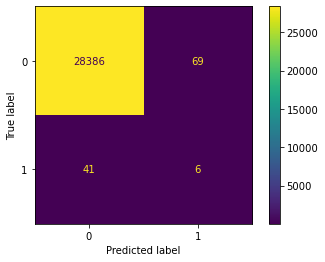

In [51]:
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(results[f'{VAR_TARGET}'], results[f'predicted_{VAR_TARGET}'])
)
disp.plot()

In [52]:
metrics.accuracy_score(results[f'{VAR_TARGET}'], results[f'predicted_{VAR_TARGET}'])

0.9961406217107571

In [53]:
print(metrics.classification_report(results[f'{VAR_TARGET}'], results[f'predicted_{VAR_TARGET}']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28455
           1       0.08      0.13      0.10        47

    accuracy                           1.00     28502
   macro avg       0.54      0.56      0.55     28502
weighted avg       1.00      1.00      1.00     28502

